In [2]:
import numpy as np
import brainflow
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations, AggOperations
import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import time
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from scipy.signal import butter, lfilter, lfilter_zi, get_window, firwin, freqz
from scipy.fft import fft

## Creacion de RAW y montaje

In [11]:
# Especifica el path de tu archivo de OpenBCI
file_path = 'Alvaro.txt'

# Leer el archivo de texto
data = pd.read_csv(file_path, comment='%', header=None)

# Extraer las columnas relevantes (suponiendo que las primeras 8 columnas después de la columna de índice son los datos de EEG) y todas las filas
eeg_data = data.iloc[100:, 1:9]
eeg_data = eeg_data.astype(float)
eeg_trans = pd.DataFrame(np.transpose(eeg_data))
eeg =eeg_trans.to_numpy()


# Verifica la estructura de los datos
# demo for data serialization using brainflow API, we recommend to use it instead pandas.to_csv()

eeg_channels=[1, 2, 3, 4, 5, 6, 7, 8]
eeg_data = eeg/1000000


# Creating MNE objects from brainflow data arrays
ch_types = ['eeg'] * len(eeg_channels)
ch_names = ["FC3","FCz","FC4","C3","Cz","C4","CP3", "CPz"]


sfreq = 250
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)
# its time to plot something!
raw.plot_psd(average=True)
plt.savefig('psd.png')

print(raw)
print(raw.info)


# Establecer cómo están conectados los electrodos (para que se puedan graficar los ICA)
montage = mne.channels.make_standard_montage('standard_1005')  # Opcional: montaje estándar de electrodos
raw.set_montage(montage)

raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=18.0).pick(picks=["mag", "eeg", "stim", "eog"])
raw.load_data()

Creating RawArray with float64 data, n_channels=8, n_times=7714
    Range : 0 ... 7713 =      0.000 ...    30.852 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\nad_a\AppData\Local\Temp\ipykernel_18868\992608227.py:30: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(average=True)
c:\Users\nad_a\mne-python\1.7.0_0\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


<RawArray | 8 x 7714 (30.9 s), ~493 kB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: FC3, FCz, FC4, C3, Cz, C4, CP3, CPz
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


c:\Users\nad_a\mne-python\1.7.0_0\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


## Filtrado

In [12]:
raw.filter(1, 100, fir_design='firwin', picks=['eeg']) 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\nad_a\AppData\Local\Temp\ipykernel_18868\1916488412.py:3: RuntimeWarning: Using n_components=8 (resulting in n_components_=8) may lead to an unstable mixing matrix estimation because the ratio between the largest (5) and smallest (3.2e-32) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(raw)


Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated


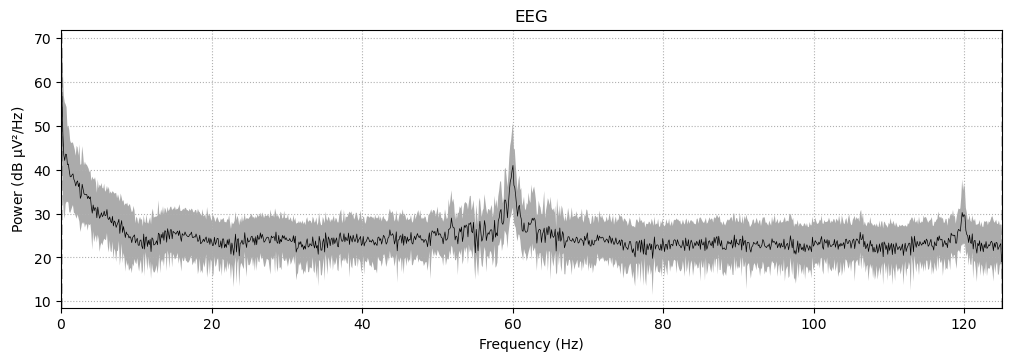

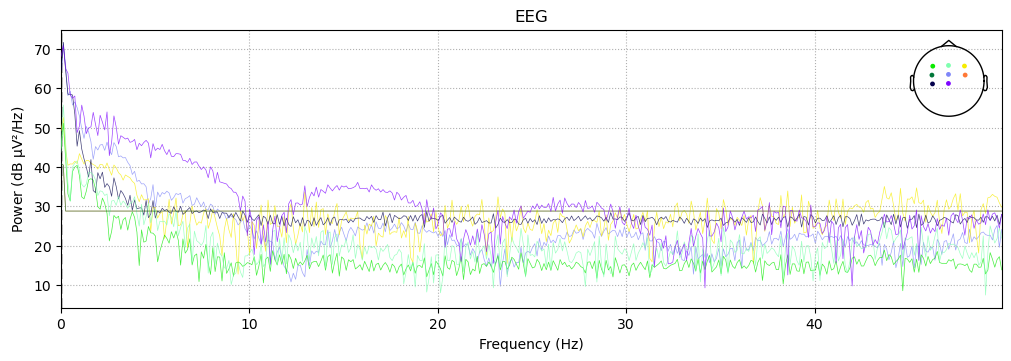

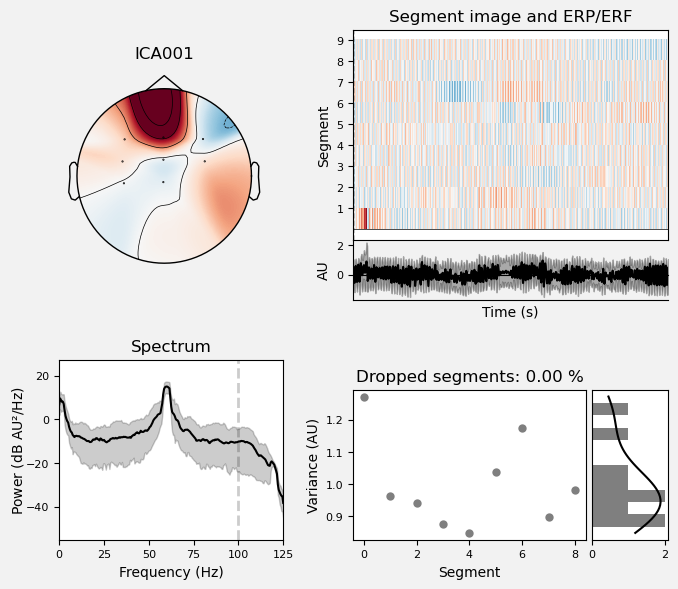

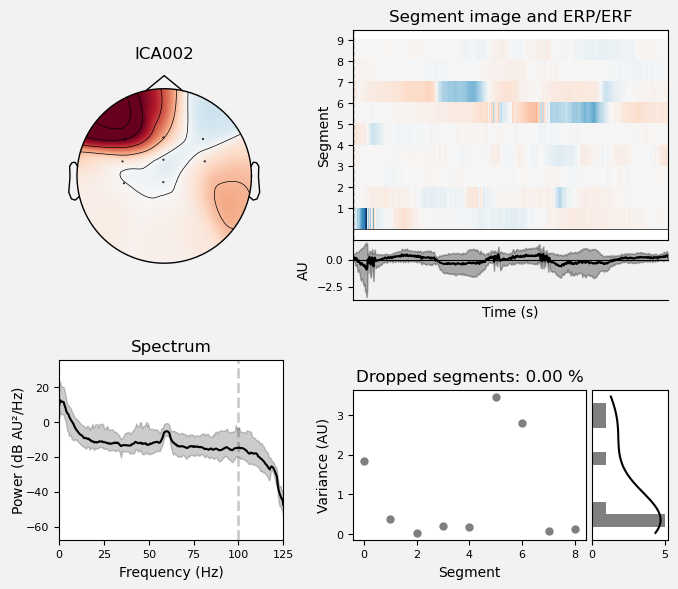

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [13]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=8, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

In [14]:
raw.filter(13, 35, fir_design='firwin', picks=['eeg']) #ondas beta
raw.set_eeg_reference('average', projection=True).apply_proj() #normalización
raw.plot() 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 255 samples (1.020 s)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


## PSD - Welch

In [15]:
def modified_welch(signal, fs, window='hamming', nperseg=1024):
    # Segmentar la señal en bloques no superpuestos
    step = nperseg // 2
    segments = [signal[i:i+nperseg] for i in range(0, len(signal)-nperseg+1, step)]
    
    # Aplicar ventana en el dominio del tiempo
    win = get_window(window, nperseg)
    windowed_segments = [segment * win for segment in segments]
    
    # Calcular FFTs de los segmentos no superpuestos
    fft_segments = [fft(segment) for segment in windowed_segments]
    
    # Combinación de FFTs para segmentos superpuestos
    combined_fft_segments = []
    for i in range(len(fft_segments) - 1):
        combined_fft = (fft_segments[i] + fft_segments[i+1]) / 2
        combined_fft_segments.append(combined_fft)
    
    # Aplicar ventana en el dominio de la frecuencia
    freq_win = firwin(3, 0.5, window='hamming')
    freq_windowed_segments = [np.convolve(segment, freq_win, mode='same') for segment in combined_fft_segments]
    
    # Calcular el periodograma modificado
    periodograms = [np.abs(segment)**2 / nperseg for segment in freq_windowed_segments]
    
    # Promediar los periodogramas
    Pxx = np.mean(periodograms, axis=0)
    
    freqs = np.fft.fftfreq(nperseg, 1/fs)
    return freqs[:nperseg//2], Pxx[:nperseg//2]


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


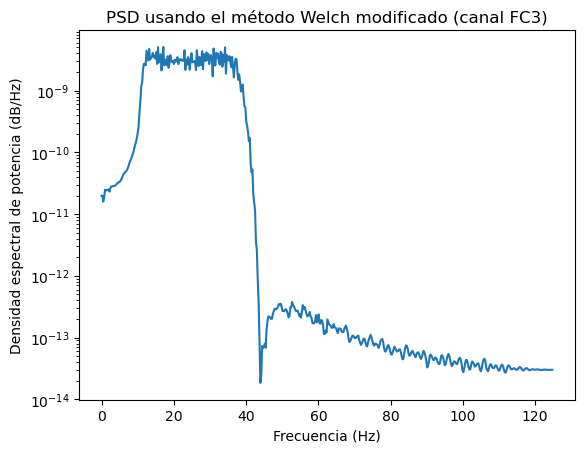

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


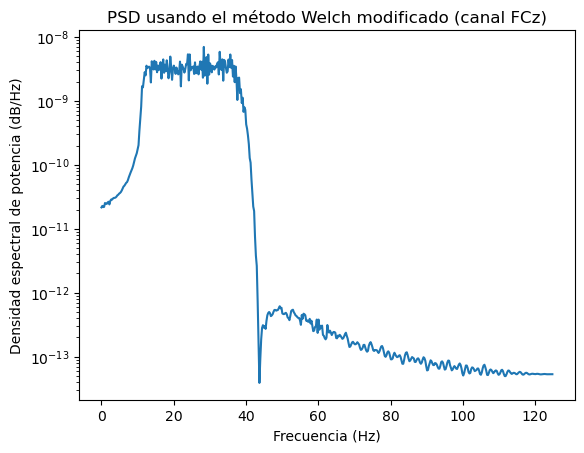

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


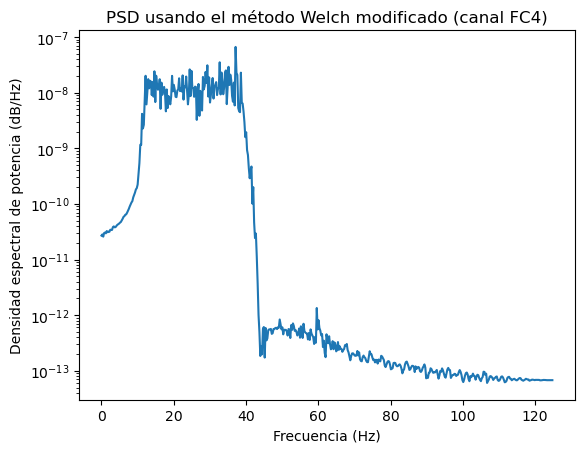

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


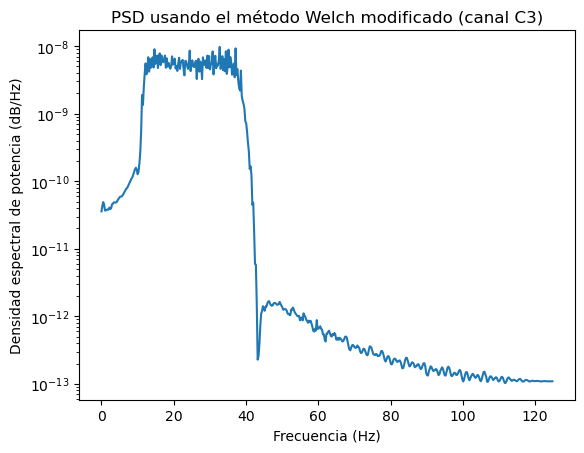

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


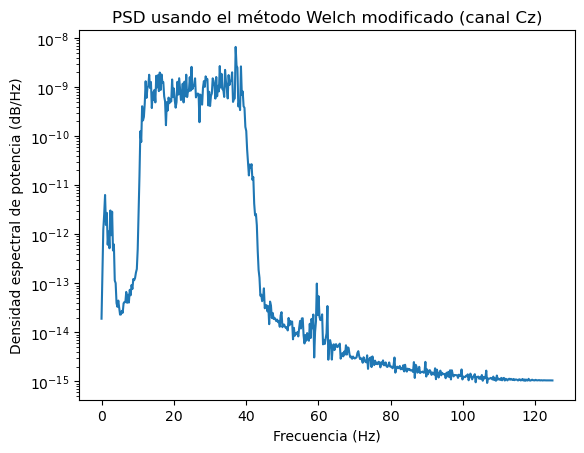

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


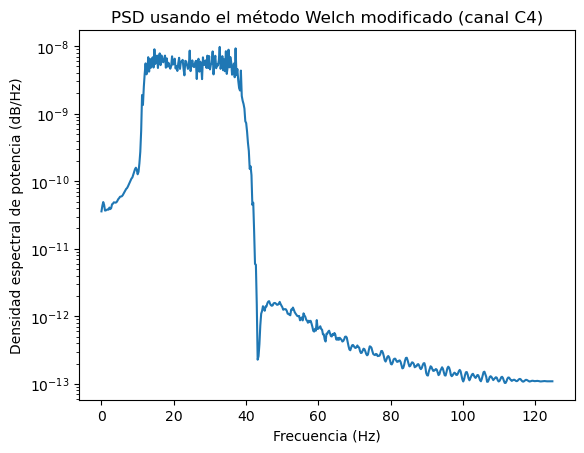

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


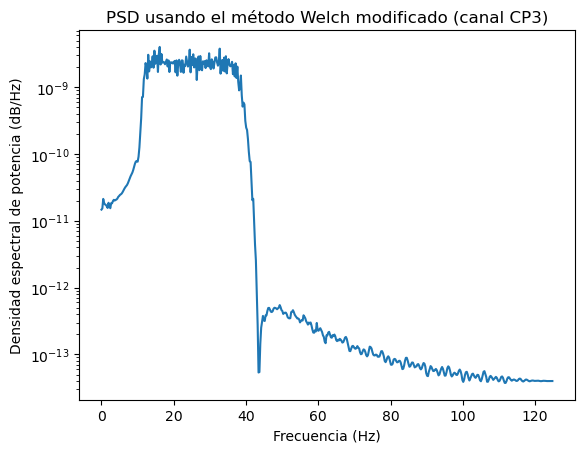

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


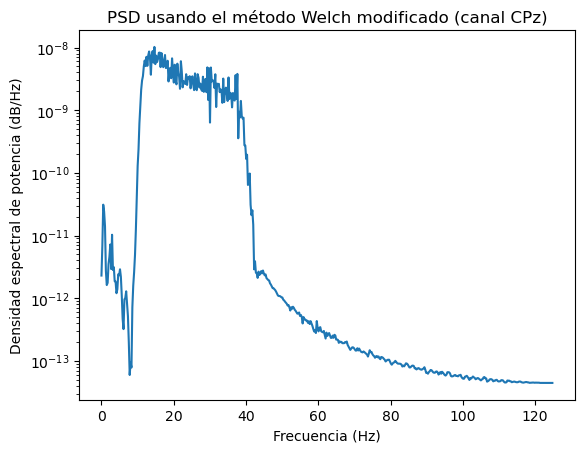

In [16]:
    
# Calcular la PSD utilizando el método modificado

for name in ch_names:

    vect, tiempos = raw.copy().pick_channels([name]).get_data(return_times=True)
    data=vect[0,:]
    f, Pxx = modified_welch(data, 250)
    # Graficar la PSD
    plt.semilogy(f, Pxx)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Densidad espectral de potencia (dB/Hz)')
    plt.title('PSD usando el método Welch modificado (canal '+name+')' )
    plt.show()


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


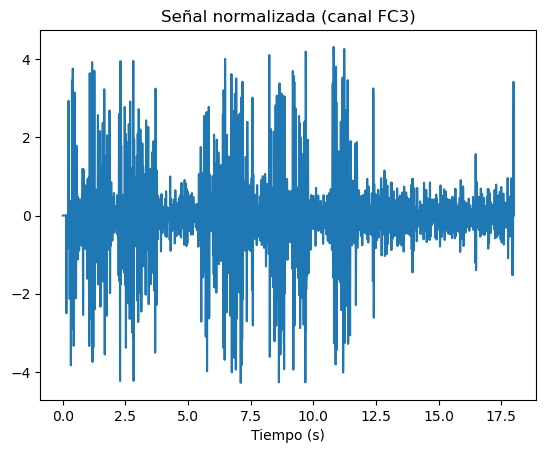

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


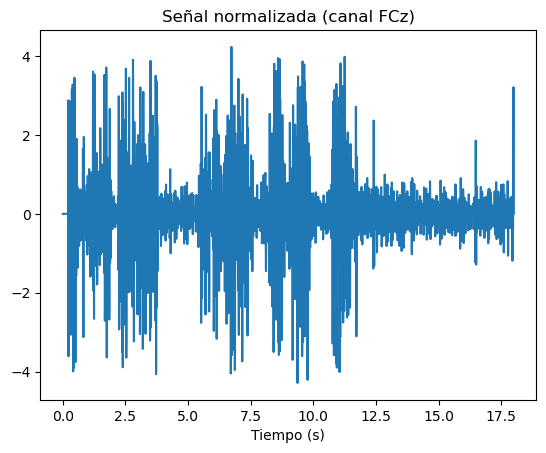

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


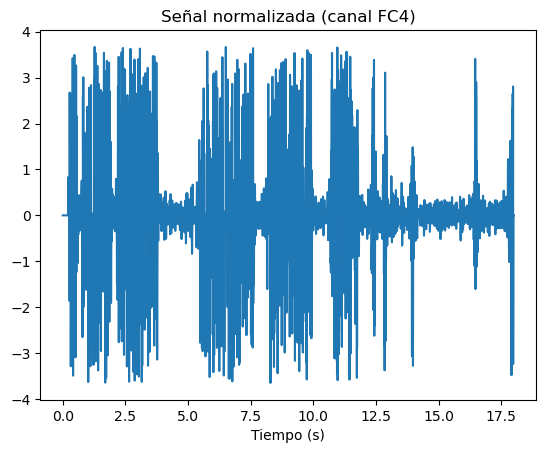

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


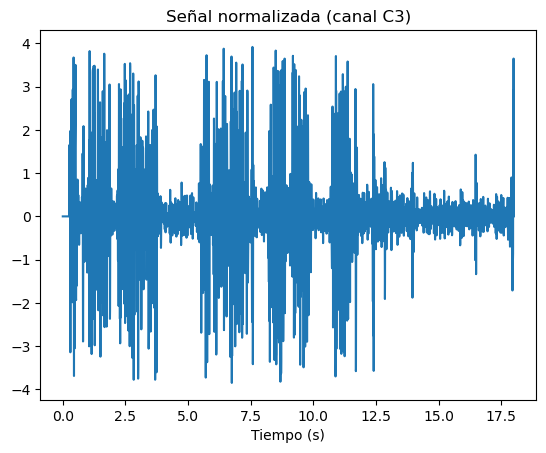

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


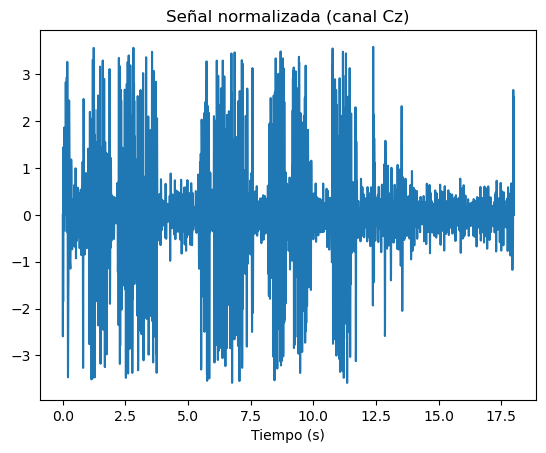

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


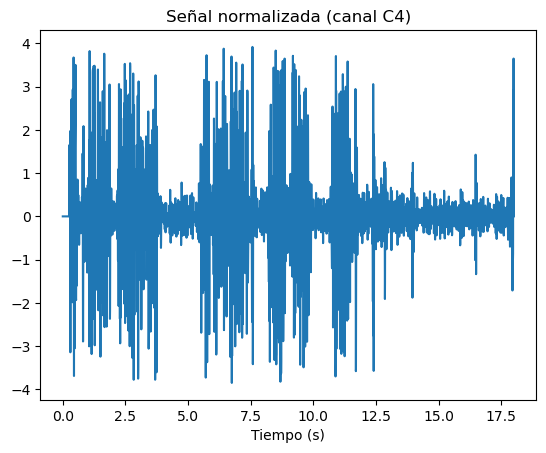

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


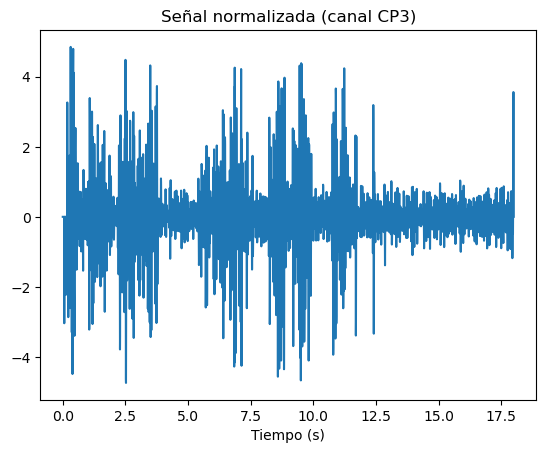

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


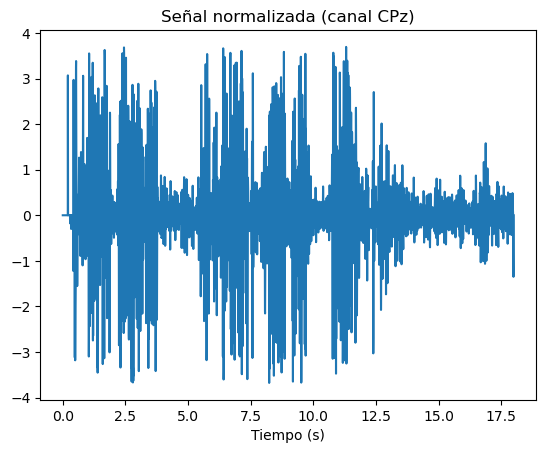

In [17]:
eeg_proc=np.empty((1, 4501), int)

for name in ch_names:
    data, tiempos = raw.copy().pick_channels([name]).get_data(return_times=True) #para trabajar con un solo canal. Poner el nombre del canal.}
    ns=(data > -0.000100) & (data < 0.000100) #valores dentro de un rango normal detectable en eeg.
    data=data*ns

    normalized_data = data / np.std(data, axis=1, keepdims=True)
    eeg_proc=np.vstack([eeg_proc, normalized_data]) #se crea una matriz en la cual se guardarán los datos pre-procesados
    dat=np.transpose(normalized_data)


    plt.plot(tiempos, dat)
    plt.xlabel('Tiempo (s)')
    plt.title('Señal normalizada (canal '+name+')' )
    plt.show()

In [18]:
df = pd.DataFrame(eeg_proc)

# Guardar el DataFrame en un archivo Excel
df.to_excel(file_path+'.xlsx', index=False, header=False)

print("El array se ha guardado en archivo.xlsx")

El array se ha guardado en archivo.xlsx


Channels marked as bad:
none
